In [5]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
batch_size = 4

# Dataset XOR Example

train_data = np.array([[0,0], [0,1], [1,0], [1,1]])
train_labels = np.array([[0], [1], [1], [0]])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.batch(batch_size)


In [9]:
print("XOR table")
pd.DataFrame(train_data).style

XOR table


,0,1
0,0,0
1,0,1
2,1,0
3,1,1


In [10]:

num_input = 2    # inputs
num_classes = 1  # output class

In [11]:
shape_in = train_data[0].shape           
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(shape_in)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(2)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)

l = loss(model, train_data, train_labels, training=False)
print("Loss test: {}".format(l))

Loss test: 0.6579325795173645


In [12]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [14]:
loss_value, grads = grad(model, train_data, train_labels)

print("Using model_default")
print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, train_data, train_labels, training=True).numpy()))

Using model_default
Step: 0, Initial Loss: 0.6579325795173645
Step: 1,         Loss: 0.6572920680046082


---------------------------------------------------------------
Epoch 000: Loss: 0.657, Accuracy: 50.000%
Epoch 050: Loss: 0.628, Accuracy: 75.000%
Epoch 100: Loss: 0.605, Accuracy: 75.000%
Epoch 150: Loss: 0.586, Accuracy: 100.000%
Epoch 200: Loss: 0.567, Accuracy: 100.000%


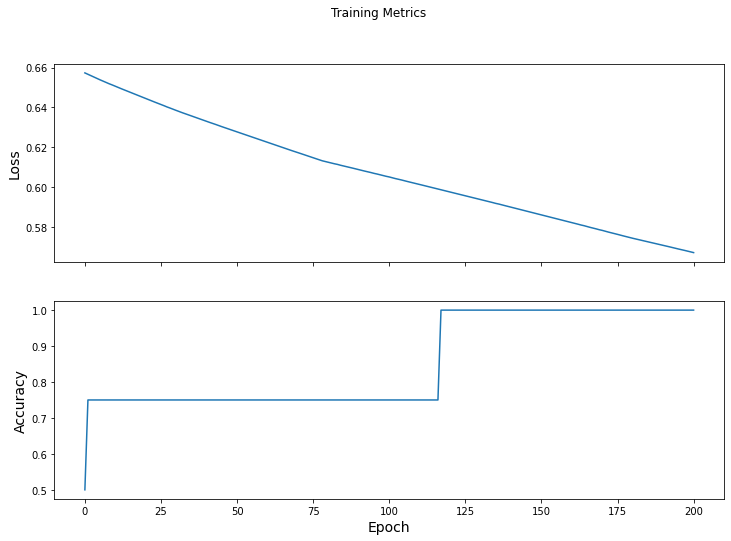

---------------------------------------------------------------


In [15]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201
print('---------------------------------------------------------------')
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()
print('---------------------------------------------------------------')

In [16]:
#Making Predictions
class_names = ['Zero','Um']
predict_dataset = tf.convert_to_tensor([
    [0,0],
    [1,1],
    [0,1]
])


predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Zero (54.1%)
Example 1 prediction: Zero (52.0%)
Example 2 prediction: Um (70.8%)
